* Split your dataset...
* Try different configs for tf-idf using only description. Evaluate.
* Add the 'title' feature: include the 'title' feature as another input along with the 'description' feature or concatenate the two features to create a new feature that contains both 'title' and 'description' information. Test different tf-idf configurations for title
  * Using descript+ title concatenated in the same string vs in separate columns?   
  * If the features are in different columns, they are treated as separate features, which helps if the features are not related or if you want to assign different weights to them
  * Using the features in separate columns can also make it easier to apply different transformations or feature engineering techniques to each one separately, use a different set of n-grams
  * leads to high-dimensional feature space -> overfitting / slow down the training and prediction times. 
  * since I'm going to try with different transformations for title and description, I used title in a separate column
  * I tried both ways, but concatenating was better
  
* adjust the processing techniques of title: not apply lemmatization vs with lemmatization
* Train and test...
* Compare the results of the classifier using both the 'description' feature alone and the concatenated 'title' and 'description' feature. 

* Based on the comparison, analyze the impact of adding the 'title' feature to the classification pipeline. If the performance improves, then you can conclude that the 'title' feature is informative and can help improve the classification accuracy. If the performance remains the same or decreases, then you may need to further investigate the feature and its relevance to the classification task.  


* The 'title' feature contain shorter texts with a more limited vocabulary, while the 'description' feature contain longer text with a wider range of vocabulary. In this case, we may need to adjust the processing techniques to suit each feature's characteristics. For the 'title' feature, we can use a more limited list of stop words to remove common words that may not be informative for the classification task. For the 'description' feature, we can use a more extensive list of stop words to remove words that are not relevant to the task. For the 'title' feature, we may not need to apply stemming or lemmatization if the vocabulary is already limited. For the 'description' feature, we can apply stemming or lemmatization to reduce the vocabulary size and group together words with the same root or meaning.

# TF-IDF

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from statistics import mean
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler #fixed import

import nltk
import re
from langdetect import detect
from scipy.sparse import hstack
import gensim
from gensim.models import Word2Vec, KeyedVectors
from nltk import word_tokenize

In [2]:
import numpy as np
np.random.seed(42)  # Set random seed for numpy

import random
random.seed(42)  # Set random seed for random module

In [3]:
df = pd.read_csv("D:\\MS DATA SCIENCE\\NLP TESE\\data\\data_processed_selected.csv")
df.head()

,date,title,reason,description,zone,narrative_tfidf,narrative_embeddings,narrative_bert,narrative_tfidf_title,narrative_bert_title,...,embeddings_title,tfidf_keywords,embeddings_keywords,events_clean,results_final,events_tfidf,events_embeddings,orgs,locs,entities
0,2021-10-11 12:26:32,CTT - Encomenda entregue danificada e com etiq...,0,Bom dia venho por este meio apresentar uma rec...,Lisboa,bom dia venho meio apresentar reclamação ctt e...,bom dia venho por este meio apresentar uma rec...,Bom dia venho por este meio apresentar uma rec...,ctt encomenda entregar danificar etiqueta envi...,ctt - encomenda entregue danificada e com etiq...,...,ctt - encomenda entregue danificada e com etiq...,apresentar reclamação caixa figura envio israe...,apresentar uma reclamação tinha caixa figura e...,venho apresentar enviei destinado feito proteg...,"[('CTT', 'B-ORGANIZACAO'), ('Israel', 'B-LOCAL...",venho apresentar enviar destinar fazer protege...,venho apresentar enviei destinado feito proteg...,"CTT, Aboboda",Israel,"CTT, Aboboda, Israel"
1,2021-08-31 23:20:15,CTT - Carta com certificado rasgado!,1,- Boa Noite!\r\n\r\n- Venho por este meio recl...,Coimbra,bom noite venho meio reclamar data ás durante ...,- boa noite!\r\n\r\n- venho por este meio recl...,- Boa Noite! Venho por este meio reclamar que ...,ctt carta certificar rasgar bom noite venho me...,ctt - carta com certificado rasgado! - Boa No...,...,ctt - carta com certificado rasgado !,lilia pimentel certificar profissional passage...,lilia pimentel certificado profissional passag...,venho reclamar deparei -me continha tem,"[('Lilia', 'B-PESSOA'), ('Pimentel', 'I-PESSOA')]",venho reclamar deparar conter,venho reclamar deparei - me continha tem,NaN,NaN,NaN
2,2021-02-01 19:08:32,CTT - Encomenda registada que nunca chegou ao ...,2,"Boa tarde,\r\nNo dia 17 de Dezembro de 2020 en...",Aveiro,bom tarde dia dezembro enviar encomenda França...,"boa tarde,\r\nno dia 00 de dezembro de 0000 en...","Boa tarde, No dia 17 de Dezembro de 2020 envie...",ctt encomenda registar nunca chegar destine o ...,ctt - encomenda registada que nunca chegou ao ...,...,ctt - encomenda registada que nunca chegou ao ...,frança correio registar frança correio encomen...,frança em correio registado frança em correio ...,enviei registado vejo chegou saiu chegou tem p...,"[('França', 'B-LOCAL'), ('Roissy', 'B-ORGANIZA...",enviar registar vejo chegar sair chegar passar...,enviei registado vejo chegou saiu chegou tem p...,Roissy,"França, ROISSY","Roissy, França, ROISSY"
3,2018-04-19 09:04:34,CTT - Correio Verde,2,"Bom dia,\n\nPretendia esclarecer uma situação ...",Lisboa,bom dia pretender esclarecer situação ocorrer ...,"bom dia,\n\npretendia esclarecer uma situação ...","Bom dia, Pretendia esclarecer uma situação que...",ctt correio verde bom dia pretender esclarecer...,"ctt - correio verde Bom dia, Pretendia esclar...",...,ctt - correio verde,pretender esclarecer situação pretender esclar...,pretendia esclarecer uma situação pretendia es...,pretendia esclarecer ocorreu desloquei dado fe...,"[('El', 'B-LOCAL'), ('Corte', 'I-LOCAL'), ('In...",pretender esclarecer ocorrer desloquei dar fec...,pretendia esclarecer ocorreu desloquei dado fe...,Correio,"El Corte Inglés, Lisboa Verde","Correio, El Corte Inglés, Lisboa Verde"
4,2019-07-04 10:20:41,"CTT - Aviso de recepção da carta registada, pr...",2,venho por este meio solicitar a vossa ajuda pa...,Porto,venho meio solicitar vosso ajudar saber onde e...,venho por este meio solicitar a vossa ajuda pa...,venho por este meio solicitar a vossa ajuda pa...,ctt aviso recepção carta registar preciso urge...,"ctt - aviso de recepção da carta registada, pr...",...,"ctt - aviso de recepção da carta registada , p...",papal centro pois preciso urgentemente pois pr...,papais para o centro pois preciso dele urgente...,venho solicitar saber onde se encontra regista...,[],venho solicitar saber onde encontrar registar ...,venho solicitar saber onde se encontra regista...,NaN,NaN,NaN


In [27]:
#convert reason to numbers
reason_dict ={'Mau Serviço Prestado': 0, 'Condições de entrega': 1, 'Atraso de entrega': 2, 
               'Enganos': 3}
df['reason'].replace(reason_dict, inplace=True)
df['reason'].unique()

array([0, 1, 2, 3], dtype=int64)

# TF-IDF

## without title

Já experimentei antes diferentes configs em find optimal tf-idf parameters mas agora vou testar com configs mais 'detalhadas'.

In [12]:
y=df['reason']
X = df.loc[:, df.columns != 'reason']

In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Print the shape of each set
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15701, 21)
y_train shape: (15701,)
X_val shape: (3364, 21)
y_val shape: (3364,)
X_test shape: (3365, 21)
y_test shape: (3365,)


In [14]:
X_train=X_train['narrative_tfidf']
X_val=X_val['narrative_tfidf']
X_test=X_test['narrative_tfidf']

In [15]:
tfidf_configs = [{'ngram_range': (1,1), 'min_df': 2},
                  # exclude terms that appear in more than 50% of the documents
                  {'ngram_range': (1,2), 'max_df':0.5, 'min_df':2},
                  # exclude terms that appear in less than two documents
                  {'ngram_range': (1,2), 'max_df':0.95 , 'min_df':2},
                  {'ngram_range': (1,3), 'max_df':0.5, 'min_df': 2},
                  {'ngram_range': (1,3), 'max_df':0.95, 'min_df': 2}]

In [16]:
classifiers = [KNeighborsClassifier(),
               DecisionTreeClassifier(), 
               RandomForestClassifier(), 
               GradientBoostingClassifier(),
               XGBClassifier(), 
               MultinomialNB(),
               LinearSVC()]

In [13]:
def evaluate_config(X_train, y_train, X_val, y_val, classifiers, tfidf_configs):
    results = {}
    for clf in classifiers:
        for tfidf_config in tfidf_configs:
            vectorizer = TfidfVectorizer(**tfidf_config)
            X_train_tf= vectorizer.fit_transform(X_train)
            X_val_tf = vectorizer.transform(X_val)
            clf.fit(X_train_tf, y_train)
            y_val_pred = clf.predict(X_val_tf)
            confusion_mat = confusion_matrix(y_true=y_val, y_pred=y_val_pred, labels=[0,1,2,3])
            class_rep= classification_report(y_val, y_val_pred)
            results[(str(clf), str(tfidf_config))] = confusion_mat
            print(str(clf),str(tfidf_config))
            print(class_rep)
            print(confusion_mat)
            print('\n')

In [14]:
# results= evaluate_config(X_train, y_train, X_val, y_val, classifiers, tfidf_configs)

evaluate_config(X_train, y_train, X_val, y_val, classifiers, tfidf_configs)

# for config, confusion_mat in results.items():
#     print(config)
#     print(confusion_mat)
#     print()

KNeighborsClassifier() {'ngram_range': (1, 1), 'min_df': 2}
              precision    recall  f1-score   support

           0       0.52      0.58      0.55      1195
           1       0.24      0.10      0.14       333
           2       0.67      0.76      0.71      1609
           3       0.26      0.11      0.15       227

    accuracy                           0.58      3364
   macro avg       0.42      0.39      0.39      3364
weighted avg       0.55      0.58      0.56      3364

[[ 690   61  404   40]
 [ 178   34  103   18]
 [ 354   26 1216   13]
 [  95   21   86   25]]


KNeighborsClassifier() {'ngram_range': (1, 2), 'max_df': 0.5, 'min_df': 2}
              precision    recall  f1-score   support

           0       0.52      0.61      0.56      1195
           1       0.29      0.13      0.18       333
           2       0.69      0.75      0.72      1609
           3       0.24      0.09      0.13       227

    accuracy                           0.59      3364
   macro 

RandomForestClassifier() {'ngram_range': (1, 3), 'max_df': 0.95, 'min_df': 2}
              precision    recall  f1-score   support

           0       0.61      0.60      0.61      1195
           1       0.67      0.02      0.05       333
           2       0.67      0.90      0.76      1609
           3       1.00      0.01      0.03       227

    accuracy                           0.65      3364
   macro avg       0.74      0.38      0.36      3364
weighted avg       0.67      0.65      0.59      3364

[[ 718    0  477    0]
 [ 181    8  144    0]
 [ 162    2 1445    0]
 [ 116    2  106    3]]


GradientBoostingClassifier() {'ngram_range': (1, 1), 'min_df': 2}
              precision    recall  f1-score   support

           0       0.59      0.66      0.62      1195
           1       0.47      0.06      0.11       333
           2       0.71      0.85      0.77      1609
           3       0.41      0.11      0.17       227

    accuracy                           0.65      3364


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...) {'ngram_range': (1, 3), 'max_df': 0.95, 'min_df': 2}
              precision    recall  f1-score   support

           0       0.57      0.64      0.61      1195
           1       0.36      0.07      0.12       333
           2       0.72

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultinomialNB() {'ngram_range': (1, 1), 'min_df': 2}
              precision    recall  f1-score   support

           0       0.60      0.56      0.58      1195
           1       0.00      0.00      0.00       333
           2       0.64      0.90      0.75      1609
           3       0.00      0.00      0.00       227

    accuracy                           0.63      3364
   macro avg       0.31      0.37      0.33      3364
weighted avg       0.52      0.63      0.57      3364

[[ 667    0  528    0]
 [ 188    0  145    0]
 [ 153    0 1456    0]
 [  97    0  130    0]]




d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultinomialNB() {'ngram_range': (1, 2), 'max_df': 0.5, 'min_df': 2}
              precision    recall  f1-score   support

           0       0.63      0.49      0.55      1195
           1       0.00      0.00      0.00       333
           2       0.62      0.94      0.75      1609
           3       0.00      0.00      0.00       227

    accuracy                           0.62      3364
   macro avg       0.31      0.36      0.32      3364
weighted avg       0.52      0.62      0.55      3364

[[ 581    0  614    0]
 [ 166    0  167    0]
 [  89    0 1520    0]
 [  82    0  145    0]]




d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultinomialNB() {'ngram_range': (1, 2), 'max_df': 0.95, 'min_df': 2}
              precision    recall  f1-score   support

           0       0.64      0.48      0.55      1195
           1       0.00      0.00      0.00       333
           2       0.62      0.95      0.75      1609
           3       0.00      0.00      0.00       227

    accuracy                           0.62      3364
   macro avg       0.31      0.36      0.32      3364
weighted avg       0.52      0.62      0.55      3364

[[ 574    0  621    0]
 [ 162    0  171    0]
 [  87    0 1522    0]
 [  80    0  147    0]]




d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultinomialNB() {'ngram_range': (1, 3), 'max_df': 0.5, 'min_df': 2}
              precision    recall  f1-score   support

           0       0.63      0.51      0.56      1195
           1       0.00      0.00      0.00       333
           2       0.63      0.94      0.75      1609
           3       0.00      0.00      0.00       227

    accuracy                           0.63      3364
   macro avg       0.31      0.36      0.33      3364
weighted avg       0.52      0.63      0.56      3364

[[ 606    0  589    0]
 [ 167    0  166    0]
 [  99    0 1510    0]
 [  91    0  136    0]]




d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultinomialNB() {'ngram_range': (1, 3), 'max_df': 0.95, 'min_df': 2}
              precision    recall  f1-score   support

           0       0.64      0.50      0.56      1195
           1       0.00      0.00      0.00       333
           2       0.63      0.94      0.75      1609
           3       0.00      0.00      0.00       227

    accuracy                           0.63      3364
   macro avg       0.32      0.36      0.33      3364
weighted avg       0.53      0.63      0.56      3364

[[ 597    0  598    0]
 [ 163    0  170    0]
 [  91    0 1518    0]
 [  85    0  142    0]]


LinearSVC() {'ngram_range': (1, 1), 'min_df': 2}
              precision    recall  f1-score   support

           0       0.58      0.62      0.59      1195
           1       0.28      0.11      0.16       333
           2       0.71      0.81      0.75      1609
           3       0.38      0.22      0.27       227

    accuracy                           0.63      3364
   macro avg       0.48   

In [24]:
def evaluate_config_cv(X_train, y_train, X_val, y_val, classifiers, tfidf_configs, n_splits=5):
    results = {}
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for clf in classifiers:
        for tfidf_config in tfidf_configs:
            vectorizer = TfidfVectorizer(**tfidf_config)
            metrics = {
                'accuracy': [],
                'precision': [],
                'recall': [],
                'f1': []
            }
            for train_index, val_index in skf.split(X_train, y_train):
                X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
                y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

                X_train_tf = vectorizer.fit_transform(X_train_fold)
                X_val_tf = vectorizer.transform(X_val_fold)

                clf.fit(X_train_tf, y_train_fold)
                y_val_pred = clf.predict(X_val_tf)
                
                accuracy = accuracy_score(y_val_fold, y_val_pred)
                class_rep = classification_report(y_val_fold, y_val_pred, output_dict=True)
                metrics['accuracy'].append(accuracy)
                metrics['precision'].append(class_rep['macro avg']['precision'])
                metrics['recall'].append(class_rep['macro avg']['recall'])
                metrics['f1'].append(class_rep['macro avg']['f1-score'])

            avg_metrics = {
                'accuracy': np.mean(metrics['accuracy']),
                'precision': np.mean(metrics['precision']),
                'recall': np.mean(metrics['recall']),
                'f1': np.mean(metrics['f1'])
            }

            results[(str(clf), str(tfidf_config))] = avg_metrics

    return results

## best without title

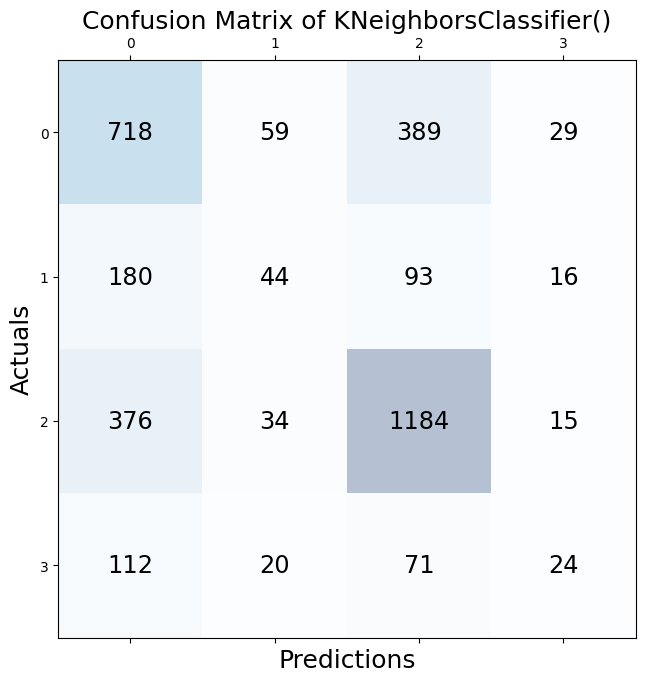

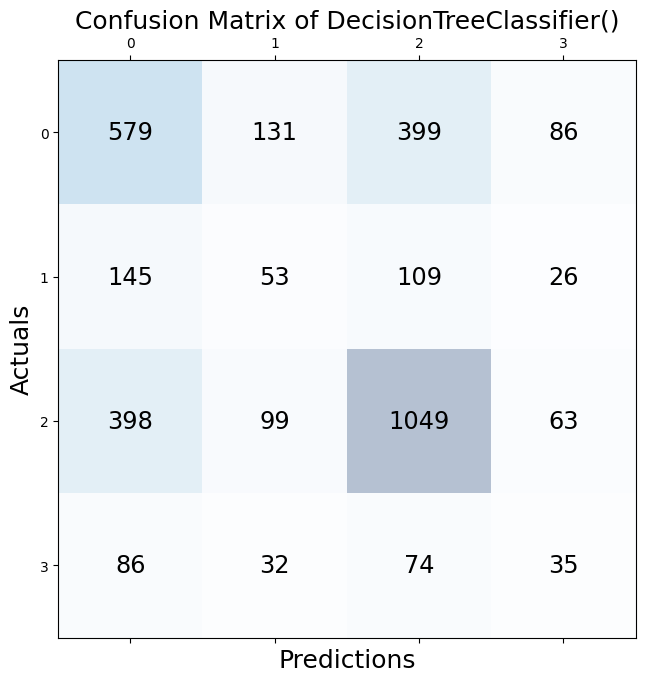

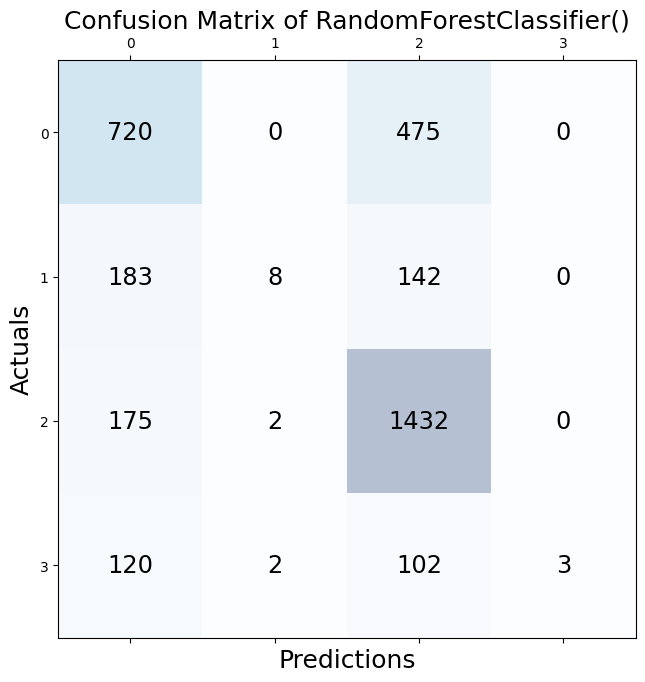

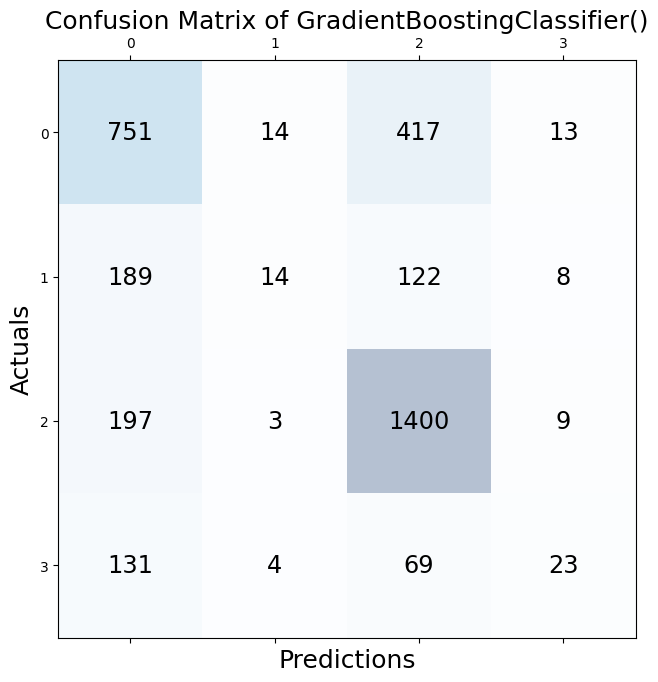

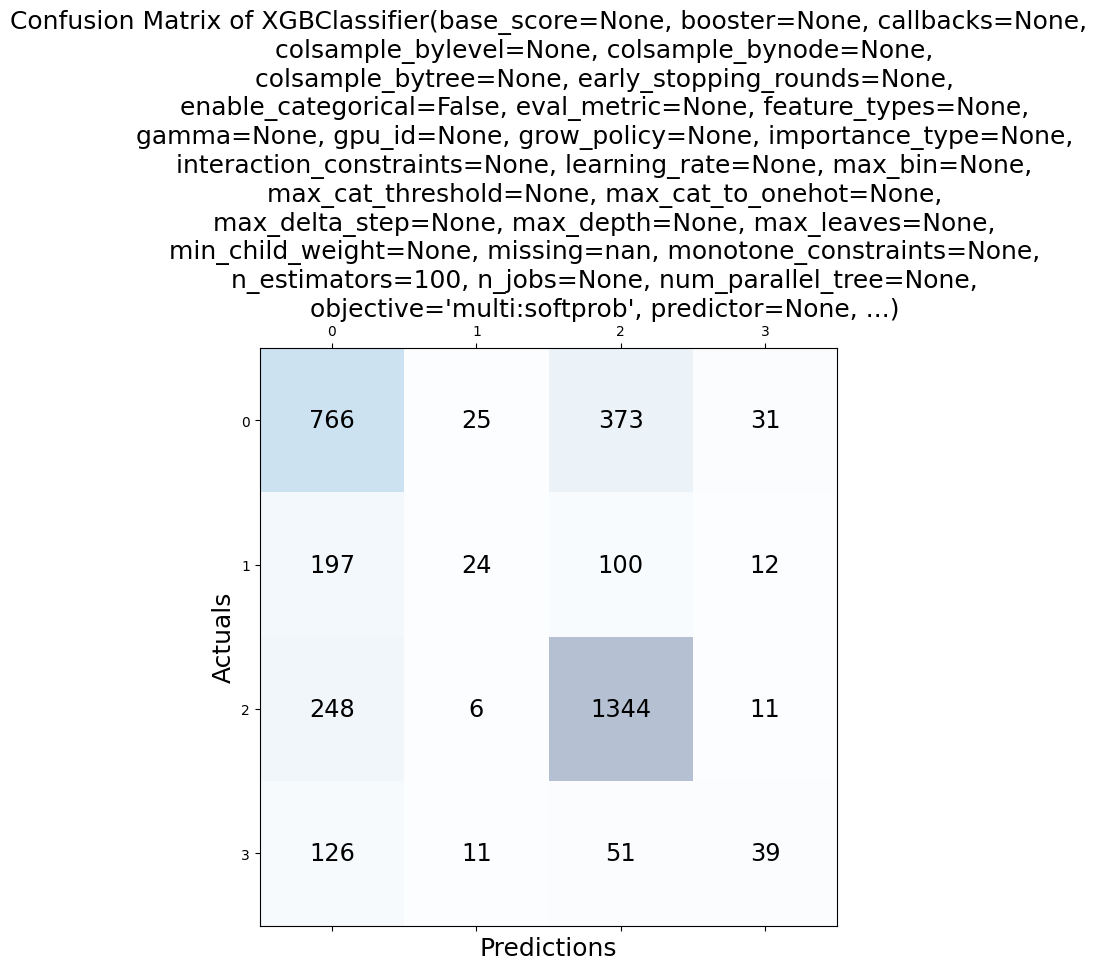

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


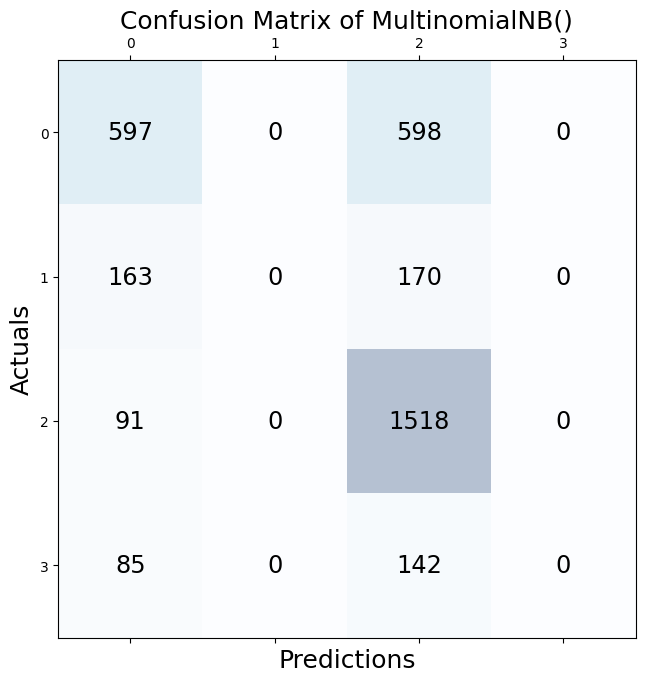

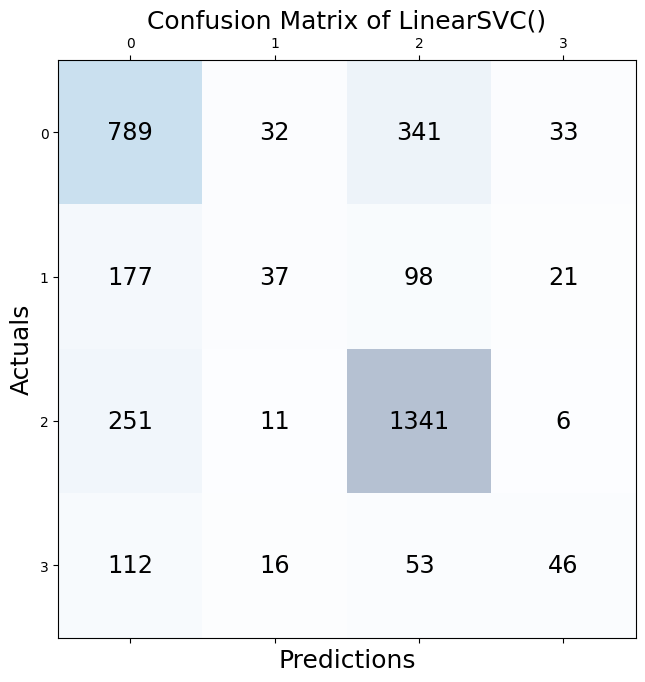

In [20]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_tf= vectorizer.fit_transform(X_train)
X_val_tf = vectorizer.transform(X_val)
for clf in classifiers:
    clf.fit(X_train_tf, y_train)
    y_val_pred = clf.predict(X_val_tf)
    confusion_mat = confusion_matrix(y_true=y_val, y_pred=y_val_pred, labels=[0,1,2,3])
    class_rep= classification_report(y_val, y_val_pred)
    # Print the confusion matrix using Matplotlib
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confusion_mat.shape[0]):
        for j in range(confusion_mat.shape[1]):
            ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix of {}'.format(clf), fontsize=18)
    plt.show()
    print('\n')

In [6]:
# Assuming you have already defined and fitted your vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_df=0.95, min_df=2)
X_train_tf = vectorizer.fit_transform(X_train)
vocabulary_size = len(vectorizer.vocabulary_)
print("Vocabulary size:", vocabulary_size)

Vocabulary size: 203837


## with title

"The choice of n-gram size for the title feature depends on the specific characteristics of your text data and the requirements of your classification task. However, since the title feature is typically shorter and more concise than the description feature, you might consider using a smaller n-gram range, such as unigrams (ngram_size=(1,1)) or bigrams (ngram_size=(2,2)), to capture the most important keywords or phrases in the title.

Using a smaller n-gram range can help prevent overfitting and reduce the dimensionality of the feature space, while still capturing the key information in the title. However, it's also important to experiment with different n-gram ranges and compare their performance using cross-validation or hold-out validation to determine the most effective approach for your specific application.

Additionally, you might also consider using different TF-IDF configurations for the title feature compared to the description feature, such as a different minimum document frequency threshold or weighting scheme, to better capture the unique characteristics of each feature type."

#### process title without using lemmatization

In [22]:
df['title'].iloc[0]

'CTT - Encomenda entregue danificada e com etiquetas de envios e registos diferentes'

In [32]:
import html
def HTMLEntitiesToUnicode(text):
    string=''
    for item in text.split():
        string=string+html.unescape(item)+' '
    result = string.replace('\xa0', ' ')
    return result

# function to tokenize data and remove stopwords
def process_narrative(narrative):
    stopwords_list = nltk.corpus.stopwords.words('portuguese')
    tokens = nltk.word_tokenize(narrative)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    
    # adding line to remove all tokens with numbers and punctuation
    stopwords_punc_and_numbers_removed = [word.lower() for word in stopwords_removed if word.isalpha()]

    return stopwords_punc_and_numbers_removed


# function to concat words (used in function below)
def concat_words(list_of_words):
    # remove any NaN's
    # list_of_words = [i for i in list if i is not np.nan]

    concat_words = ''
    for word in list_of_words:
        concat_words += word + ' '
    return concat_words.strip()

def clean_data(texto): #aplica-se a uma so string
    # Remove new line characters
    texto = texto.replace('\n', ' ')
    texto = texto.replace('\r', ' ')
    # Remove multiple spaces
    texto=re.sub(' +', ' ',texto)
    # Remove Emails
    texto = re.sub('\S*@\S*\s?', '',texto)
    # Remove single quotes
    texto = re.sub("\"", '', texto)
    # Remove hyperlinks
    texto = re.sub('http://\S+|https://\S+', '', texto)
    texto = re.sub('http[s]?://\S+', '', texto)
    texto = re.sub(r"http\S+", '', texto)
    texto = re.sub(r'www.\S+', '', texto)
    # Replaces repetitions of exlamation marks
    texto = re.sub(r"(\!)\1+", '!', texto)
    # Replaces repetitions of question marks
    texto = re.sub(r"(\?)\1+", '?', texto)
    # Replaces repetitions of .
    texto = re.sub(r"(\.)\1+", '.', texto)
    # Replaces repetitions of -
    texto = re.sub(r"(\-)\1+", ' ', texto)
    # Replaces repetitions of ,
    texto = re.sub(r"(\,)\1+", ' ', texto)
    return texto

In [35]:
import json
outputs=[]
for i in range(len(df)):
    raw=df['title'].iloc[i]
    raw=raw.lower()
    item=clean_data(raw)
    item=HTMLEntitiesToUnicode(item)
    if detect(item.lower())=='pt':
        processed_title = process_narrative(item)
        concatenated_string = concat_words(processed_title)
    else:
        concatenated_string=''
    outputs.append(concatenated_string)

In [36]:
df['title_tfidf_nolemma']=outputs

In [141]:
"""
Script used for cleaning corpus in order to train word embeddings.
All emails are mapped to a EMAIL token.
All numbers are mapped to 0 token.
All urls are mapped to URL token.
Different quotes are standardized.
Different hiphen are standardized.
HTML strings are removed.
All text between brackets are removed.
...
"""

from sys import stdout
import argparse
import re
import nltk

sent_tokenizer = nltk.data.load('tokenizers/punkt/portuguese.pickle')

# Punctuation list
punctuations = re.escape('!"#%\'()*+,./:;<=>?@[\\]^_`{|}~')

# ##### #
# Regex #
# ##### #
re_remove_brackets = re.compile(r'\{.*\}')
re_remove_html = re.compile(r'<(\/|\\)?.+?>', re.UNICODE)
re_transform_numbers = re.compile(r'\d', re.UNICODE)
re_transform_emails = re.compile(r'[^\s]+@[^\s]+', re.UNICODE)
re_transform_url = re.compile(r'(http|https)://[^\s]+', re.UNICODE)
# Different quotes are used.
re_quotes_1 = re.compile(r"(?u)(^|\W)[‘’′`']", re.UNICODE)
re_quotes_2 = re.compile(r"(?u)[‘’`′'](\W|$)", re.UNICODE)
re_quotes_3 = re.compile(r'(?u)[‘’`′“”]', re.UNICODE)
re_dots = re.compile(r'(?<!\.)\.\.(?!\.)', re.UNICODE)
re_punctuation = re.compile(r'([,";:]){2},', re.UNICODE)
re_hiphen = re.compile(r' -(?=[^\W\d_])', re.UNICODE)
re_tree_dots = re.compile(u'…', re.UNICODE)
# Differents punctuation patterns are used.
re_punkts = re.compile(r'(\w+)([%s])([ %s])' %
                       (punctuations, punctuations), re.UNICODE)
re_punkts_b = re.compile(r'([ %s])([%s])(\w+)' %
                         (punctuations, punctuations), re.UNICODE)
re_punkts_c = re.compile(r'(\w+)([%s])$' % (punctuations), re.UNICODE)
re_changehyphen = re.compile(u'–')
re_doublequotes_1 = re.compile(r'(\"\")')
re_doublequotes_2 = re.compile(r'(\'\')')
re_trim = re.compile(r' +', re.UNICODE)


def clean_text(text):
    """Apply all regex above to a given string."""
    text = text.lower()
    text = text.replace('\xa0', ' ')
    text = re_tree_dots.sub('...', text)
    text = re.sub('\.\.\.', '', text)
    text = re_remove_brackets.sub('', text)
    text = re_changehyphen.sub('-', text)
    text = re_remove_html.sub(' ', text)
    text = re_transform_numbers.sub('0', text)
    text = re_transform_url.sub('URL', text)
    text = re_transform_emails.sub('EMAIL', text)
    text = re_quotes_1.sub(r'\1"', text)
    text = re_quotes_2.sub(r'"\1', text)
    text = re_quotes_3.sub('"', text)
    text = re.sub('"', '', text)
    text = re_dots.sub('.', text)
    text = re_punctuation.sub(r'\1', text)
    text = re_hiphen.sub(' - ', text)
    text = re_punkts.sub(r'\1 \2 \3', text)
    text = re_punkts_b.sub(r'\1 \2 \3', text)
    text = re_punkts_c.sub(r'\1 \2', text)
    text = re_doublequotes_1.sub('\"', text)
    text = re_doublequotes_2.sub('\'', text)
    text = re_trim.sub(' ', text)
    return text.strip()

In [142]:
narrative=[]
for i in range(len(df)):
    raw=df['title'].iloc[i]
    clean= clean_text(raw)
    if detect(clean.lower())=='pt':
        processed_title = clean
    else:
        processed_title=''
    narrative.append(clean)
df['embeddings_title'] = narrative

In [38]:
# #save df as csv 
# import os
# os.makedirs("D:\\MS DATA SCIENCE\\NLP TESE\\data\\", exist_ok=True)  

In [132]:
# df.to_csv('D:\\MS DATA SCIENCE\\NLP TESE\\data\\data_processed_selected.csv', index=False, header=True)

#### try title with and without lemmatization  
with lemmatization is title_tfidf, without is title_tfidf_nolemma

In [11]:
classifiers = [
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('RandomForestClassifier', RandomForestClassifier()),
    ('GradientBoostingClassifier', GradientBoostingClassifier()),
    ('XGBClassifier', XGBClassifier()),
    ('MultinomialNB', MultinomialNB()),
    ('LinearSVC', LinearSVC())    
]

max_df=0.9 or 0.95 because the texts are short and have a similar structure,  
min_df=1 or 2 just to keep rare words but remove typos, eg,  
bigrams and trigrams because texts are short, using unigrams alone may not capture enough information?

In [6]:
tfidf_configs_title = [{'ngram_range': (1,2),
                        'min_df': 2,
                       'max_df': 0.90},
                       {'ngram_range': (1,3),
                        'min_df': 2,
                       'max_df': 0.90},
                       {'ngram_range': (2,3),
                        'min_df': 2,
                        'max_df': 0.90}]

# config das experiencias anteriores
tfidf_config_desc = {'ngram_range': (1,3),
                     'max_df': 0.95,
                     'min_df': 2}

In [12]:
feature_combinations = [
    ('tfidf_title', 'narrative_tfidf'),
    ('title_tfidf_nolemma', 'narrative_tfidf')
]

In [153]:
df=pd.read_csv("D:\\MS DATA SCIENCE\\NLP TESE\\data\\data_processed_selected.csv")

In [26]:
# replace NaN values with empty strings
df['tfidf_title'] = df['tfidf_title'].fillna('')
df['title_tfidf_nolemma'] = df['title_tfidf_nolemma'].fillna('')

In [130]:
df['embeddings_title']=df['embeddings_title'].fillna('')

In [10]:
# WITHOUT CONCATENATING
# Iterate through all combinations of feature, tfidf and classifier
for feature1, feature2 in feature_combinations:
    for tfidf_config_title in tfidf_configs_title:
        # Split data into train, validation and test sets
        X_train, X_test, y_train, y_test = train_test_split(df[[feature1, feature2]], df['reason'], test_size=0.3, stratify=df['reason'], random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)
        
        # Define tf-idf vectorizers for 'title_tfidf_nolemma' or 'title_tfidf'
        vectorizer_title = TfidfVectorizer(ngram_range=tfidf_config_title['ngram_range'], max_df=tfidf_config_title['max_df'], min_df=tfidf_config_title['min_df'])
        if feature1=='tfidf_title':
            X_train_tfidf_title = vectorizer_title.fit_transform(X_train['tfidf_title'])
            X_val_tfidf_title = vectorizer_title.transform(X_val['tfidf_title'])
        else:
            X_train_tfidf_title = vectorizer_title.fit_transform(X_train['title_tfidf_nolemma'])
            X_val_tfidf_title = vectorizer_title.transform(X_val['title_tfidf_nolemma'])
    
        # Define tf-idf vectorizer for 'narrative_tfidf'
        vectorizer_desc = TfidfVectorizer(ngram_range=tfidf_config_title['ngram_range'], max_df=tfidf_config_title['max_df'], min_df=tfidf_config_title['min_df'])
        X_train_tfidf_desc = vectorizer_desc.fit_transform(X_train['narrative_tfidf'])
        X_val_tfidf_desc = vectorizer_desc.transform(X_val['narrative_tfidf'])

        # Combine tf-idf matrices for 'title' and 'description'
        # they are both sparse matrices
        X_train_tfidf = hstack([X_train_tfidf_title, X_train_tfidf_desc])
        X_val_tfidf = hstack([X_val_tfidf_title, X_val_tfidf_desc])
        
        # Iterate through all classifiers
        for clf_name, clf in classifiers:
            # Train and predict with classifier
            clf.fit(X_train_tfidf, y_train)
            y_pred = clf.predict(X_val_tfidf)

            # Print confusion matrix results
            print(f"Features: {feature1}, {feature2} | Tfidf config for title: {tfidf_config_title} | Classifier: {clf_name}")
            print(classification_report(y_val, y_pred))

Features: tfidf_title, narrative_tfidf | Tfidf config for title: {'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.9} | Classifier: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.49      0.52      0.50      1195
           1       0.19      0.11      0.14       333
           2       0.66      0.74      0.70      1609
           3       0.40      0.15      0.22       227

    accuracy                           0.56      3364
   macro avg       0.43      0.38      0.39      3364
weighted avg       0.54      0.56      0.54      3364

Features: tfidf_title, narrative_tfidf | Tfidf config for title: {'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.9} | Classifier: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.49      0.50      0.49      1195
           1       0.18      0.15      0.16       333
           2       0.65      0.66      0.65      1609
           3       0.19      0.18      0.1

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Features: tfidf_title, narrative_tfidf | Tfidf config for title: {'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.9} | Classifier: LinearSVC
              precision    recall  f1-score   support

           0       0.58      0.63      0.61      1195
           1       0.26      0.11      0.15       333
           2       0.73      0.81      0.77      1609
           3       0.40      0.26      0.31       227

    accuracy                           0.64      3364
   macro avg       0.49      0.45      0.46      3364
weighted avg       0.61      0.64      0.62      3364

Features: tfidf_title, narrative_tfidf | Tfidf config for title: {'ngram_range': (1, 3), 'min_df': 2, 'max_df': 0.9} | Classifier: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.49      0.53      0.51      1195
           1       0.18      0.10      0.13       333
           2       0.65      0.72      0.69      1609
           3       0.41      0.15      0.22       227



d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Features: tfidf_title, narrative_tfidf | Tfidf config for title: {'ngram_range': (1, 3), 'min_df': 2, 'max_df': 0.9} | Classifier: LinearSVC
              precision    recall  f1-score   support

           0       0.59      0.64      0.62      1195
           1       0.27      0.11      0.16       333
           2       0.74      0.83      0.78      1609
           3       0.43      0.26      0.33       227

    accuracy                           0.65      3364
   macro avg       0.51      0.46      0.47      3364
weighted avg       0.62      0.65      0.63      3364

Features: tfidf_title, narrative_tfidf | Tfidf config for title: {'ngram_range': (2, 3), 'min_df': 2, 'max_df': 0.9} | Classifier: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.50      0.54      0.52      1195
           1       0.14      0.07      0.10       333
           2       0.64      0.74      0.69      1609
           3       0.40      0.11      0.18       227



d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Features: tfidf_title, narrative_tfidf | Tfidf config for title: {'ngram_range': (2, 3), 'min_df': 2, 'max_df': 0.9} | Classifier: LinearSVC
              precision    recall  f1-score   support

           0       0.58      0.63      0.60      1195
           1       0.27      0.10      0.15       333
           2       0.72      0.82      0.77      1609
           3       0.41      0.20      0.27       227

    accuracy                           0.64      3364
   macro avg       0.50      0.44      0.45      3364
weighted avg       0.60      0.64      0.61      3364

Features: title_tfidf_nolemma, narrative_tfidf | Tfidf config for title: {'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.9} | Classifier: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.49      0.55      0.52      1195
           1       0.20      0.12      0.15       333
           2       0.67      0.73      0.70      1609
           3       0.36      0.14      0.20    

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Features: title_tfidf_nolemma, narrative_tfidf | Tfidf config for title: {'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.9} | Classifier: LinearSVC
              precision    recall  f1-score   support

           0       0.58      0.64      0.61      1195
           1       0.25      0.10      0.14       333
           2       0.73      0.81      0.77      1609
           3       0.41      0.26      0.32       227

    accuracy                           0.64      3364
   macro avg       0.49      0.45      0.46      3364
weighted avg       0.61      0.64      0.62      3364

Features: title_tfidf_nolemma, narrative_tfidf | Tfidf config for title: {'ngram_range': (1, 3), 'min_df': 2, 'max_df': 0.9} | Classifier: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.49      0.56      0.52      1195
           1       0.17      0.10      0.12       333
           2       0.67      0.71      0.69      1609
           3       0.38      0.13      

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Features: title_tfidf_nolemma, narrative_tfidf | Tfidf config for title: {'ngram_range': (1, 3), 'min_df': 2, 'max_df': 0.9} | Classifier: LinearSVC
              precision    recall  f1-score   support

           0       0.59      0.64      0.62      1195
           1       0.27      0.10      0.15       333
           2       0.74      0.83      0.78      1609
           3       0.44      0.27      0.34       227

    accuracy                           0.65      3364
   macro avg       0.51      0.46      0.47      3364
weighted avg       0.62      0.65      0.63      3364

Features: title_tfidf_nolemma, narrative_tfidf | Tfidf config for title: {'ngram_range': (2, 3), 'min_df': 2, 'max_df': 0.9} | Classifier: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.50      0.54      0.52      1195
           1       0.13      0.07      0.09       333
           2       0.65      0.74      0.69      1609
           3       0.42      0.12      

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Features: title_tfidf_nolemma, narrative_tfidf | Tfidf config for title: {'ngram_range': (2, 3), 'min_df': 2, 'max_df': 0.9} | Classifier: LinearSVC
              precision    recall  f1-score   support

           0       0.59      0.63      0.61      1195
           1       0.30      0.11      0.16       333
           2       0.72      0.82      0.77      1609
           3       0.44      0.22      0.29       227

    accuracy                           0.64      3364
   macro avg       0.51      0.45      0.46      3364
weighted avg       0.61      0.64      0.62      3364



best without concatenating: using tfidf_title   

(1,3), 0.95, 2 : LSVC f1=0.47 and acc=0.65

In [19]:
# Define the tf-idf configuration for the CONCATENATED text
tfidf_configs = [{'ngram_range': (1,2),
                        'min_df': 2,
                       'max_df': 0.95},
                       {'ngram_range': (1,3),
                        'min_df': 2,
                       'max_df': 0.95}]

feature_combinations = [
    ('tfidf_title', 'narrative_tfidf'),
    ('title_tfidf_nolemma', 'narrative_tfidf')
]
# Split data into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(df, df['reason'], test_size=0.3, stratify=df['reason'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Iterate through all combinations of feature and classifier
for (feature1,feature2) in feature_combinations:
    for tfidf_config in tfidf_configs:
        
        # Concatenate the 'title' and 'description' columns
        X_train_text = X_train[feature1] + ' ' + X_train[feature2]
        X_val_text = X_val[feature1] + ' ' + X_val[feature2]

        # Define the tf-idf vectorizer for the concatenated text
        vectorizer =TfidfVectorizer(ngram_range=tfidf_config['ngram_range'], max_df=tfidf_config['max_df'], min_df=tfidf_config['min_df'])
        X_train_tfidf = vectorizer.fit_transform(X_train_text)
        X_val_tfidf = vectorizer.transform(X_val_text)

        # Iterate through all classifiers
        for clf_name, clf in classifiers:
            # Train and predict with classifier
            clf.fit(X_train_tfidf, y_train)
            y_pred = clf.predict(X_val_tfidf)

            # Print confusion matrix results
            print(f"Feature:  {feature1}, {feature2}| Tfidf config: {tfidf_config} | Classifier: {clf_name}")
            print(classification_report(y_val, y_pred))

Feature:  tfidf_title, narrative_tfidf| Tfidf config: {'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.95} | Classifier: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.53      0.58      0.55      1195
           1       0.22      0.11      0.15       333
           2       0.69      0.76      0.72      1609
           3       0.32      0.16      0.22       227

    accuracy                           0.59      3364
   macro avg       0.44      0.40      0.41      3364
weighted avg       0.56      0.59      0.57      3364

Feature:  tfidf_title, narrative_tfidf| Tfidf config: {'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.95} | Classifier: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.48      0.49      0.49      1195
           1       0.21      0.19      0.20       333
           2       0.67      0.68      0.67      1609
           3       0.20      0.18      0.19       227

    acc

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Feature:  tfidf_title, narrative_tfidf| Tfidf config: {'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.95} | Classifier: LinearSVC
              precision    recall  f1-score   support

           0       0.59      0.66      0.62      1195
           1       0.30      0.10      0.15       333
           2       0.74      0.83      0.78      1609
           3       0.44      0.26      0.32       227

    accuracy                           0.66      3364
   macro avg       0.52      0.46      0.47      3364
weighted avg       0.62      0.66      0.63      3364

Feature:  tfidf_title, narrative_tfidf| Tfidf config: {'ngram_range': (1, 3), 'min_df': 2, 'max_df': 0.95} | Classifier: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.52      0.58      0.55      1195
           1       0.23      0.12      0.16       333
           2       0.69      0.75      0.72      1609
           3       0.34      0.16      0.22       227

    accuracy        

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Feature:  tfidf_title, narrative_tfidf| Tfidf config: {'ngram_range': (1, 3), 'min_df': 2, 'max_df': 0.95} | Classifier: LinearSVC
              precision    recall  f1-score   support

           0       0.60      0.68      0.63      1195
           1       0.34      0.10      0.15       333
           2       0.75      0.83      0.79      1609
           3       0.50      0.26      0.34       227

    accuracy                           0.67      3364
   macro avg       0.54      0.47      0.48      3364
weighted avg       0.64      0.67      0.64      3364

Feature:  title_tfidf_nolemma, narrative_tfidf| Tfidf config: {'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.95} | Classifier: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.52      0.59      0.55      1195
           1       0.25      0.13      0.17       333
           2       0.69      0.76      0.73      1609
           3       0.33      0.15      0.21       227

    accuracy

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Feature:  title_tfidf_nolemma, narrative_tfidf| Tfidf config: {'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.95} | Classifier: LinearSVC
              precision    recall  f1-score   support

           0       0.59      0.66      0.62      1195
           1       0.30      0.09      0.14       333
           2       0.74      0.83      0.78      1609
           3       0.47      0.26      0.34       227

    accuracy                           0.66      3364
   macro avg       0.53      0.46      0.47      3364
weighted avg       0.62      0.66      0.63      3364

Feature:  title_tfidf_nolemma, narrative_tfidf| Tfidf config: {'ngram_range': (1, 3), 'min_df': 2, 'max_df': 0.95} | Classifier: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.52      0.59      0.55      1195
           1       0.24      0.13      0.17       333
           2       0.69      0.74      0.72      1609
           3       0.35      0.15      0.21       227

    

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Feature:  title_tfidf_nolemma, narrative_tfidf| Tfidf config: {'ngram_range': (1, 3), 'min_df': 2, 'max_df': 0.95} | Classifier: LinearSVC
              precision    recall  f1-score   support

           0       0.60      0.67      0.63      1195
           1       0.34      0.09      0.14       333
           2       0.75      0.84      0.79      1609
           3       0.50      0.28      0.36       227

    accuracy                           0.67      3364
   macro avg       0.55      0.47      0.48      3364
weighted avg       0.64      0.67      0.64      3364



best concatenating: tfidf_title

(1,3), 0.95, 2 : LSVC f1=0.48 acc=0.67 

so cancatenating is best

## best with title  

Feature:  tfidf_title, narrative_tfidf| Tfidf config: {'ngram_range': (1, 3), 'min_df': 2, 'max_df': 0.95} | Classifier: LinearSVC

In [28]:
# Split data into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(df, df['reason'], test_size=0.3, stratify=df['reason'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)
# Concatenate the 'title' and 'description' columns
X_train_text = X_train['tfidf_title'] + ' ' + X_train['narrative_tfidf']
X_val_text = X_val['tfidf_title'] + ' ' + X_val['narrative_tfidf']

# Define the tf-idf vectorizer for the concatenated text
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)

In [72]:
classifiers = [KNeighborsClassifier(),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               GradientBoostingClassifier(),
               XGBClassifier(),
               MultinomialNB(),
               LinearSVC() 
]

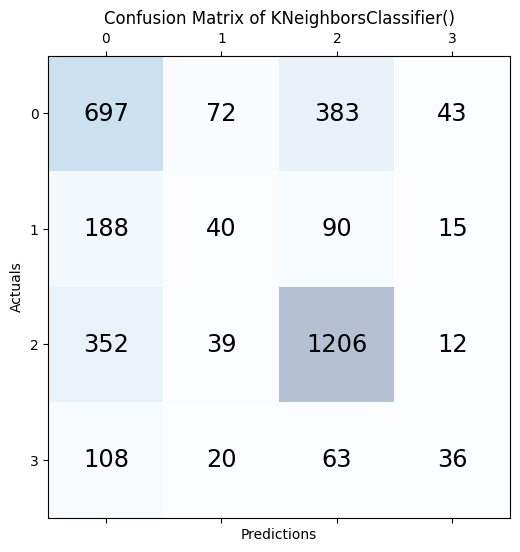

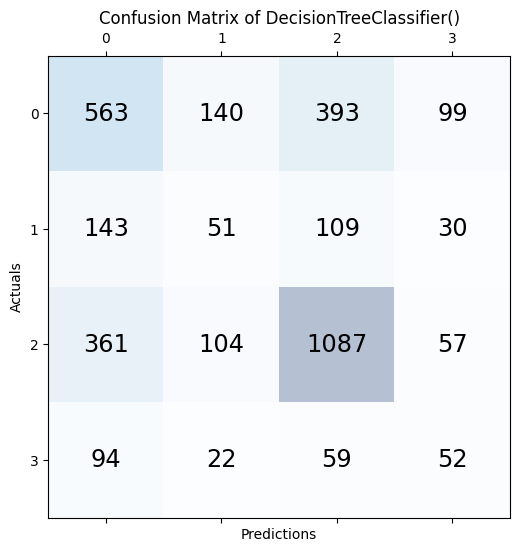

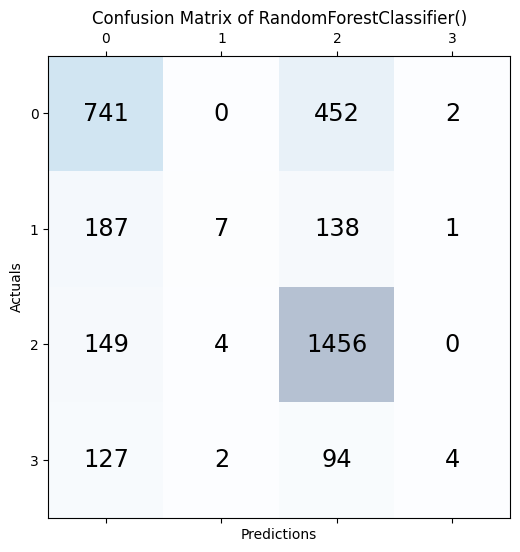

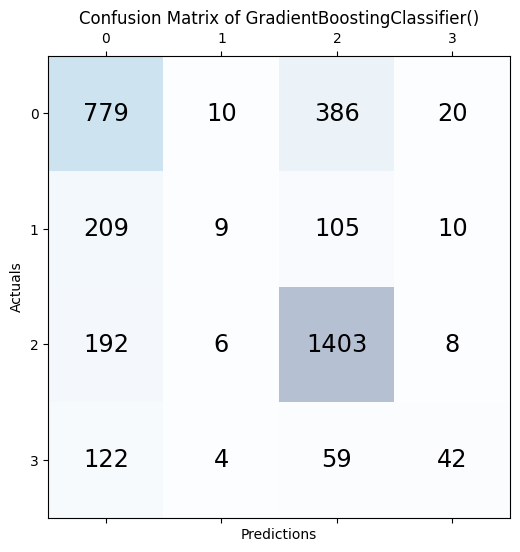

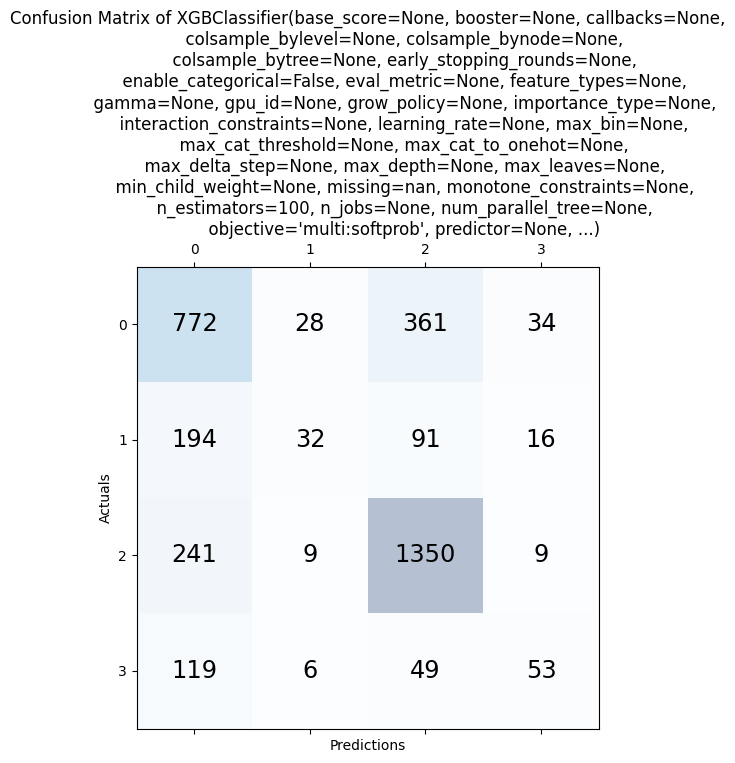

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


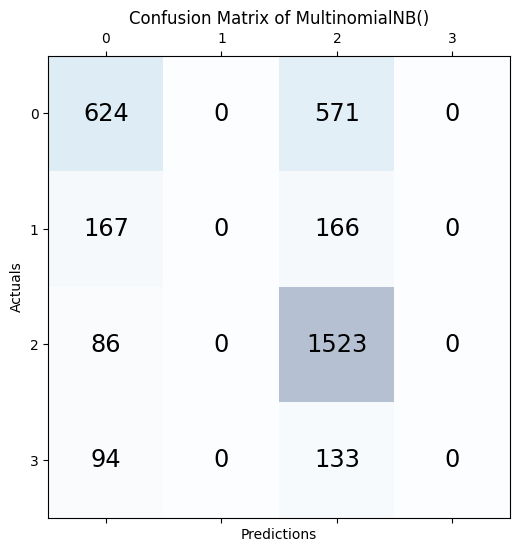

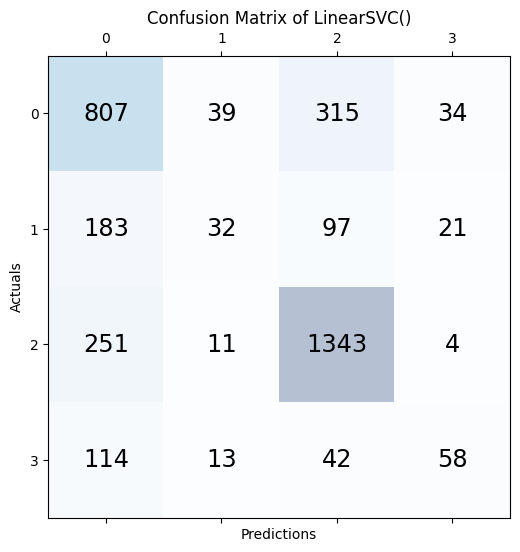

In [30]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_tf= vectorizer.fit_transform(X_train_text)
X_val_tf = vectorizer.transform(X_val_text)
for clf in classifiers:
    clf.fit(X_train_tf, y_train)
    y_val_pred = clf.predict(X_val_tf)
    confusion_mat = confusion_matrix(y_true=y_val, y_pred=y_val_pred, labels=[0,1,2,3])
    class_rep= classification_report(y_val, y_val_pred)
    # Print the confusion matrix using Matplotlib
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confusion_mat.shape[0]):
        for j in range(confusion_mat.shape[1]):
            ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Confusion Matrix of {}'.format(clf), fontsize=12)
    plt.show()
    print('\n')

In [ ]:
# Assuming you have already defined and fitted your vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_df=0.95, min_df=2)
X_train_tf = vectorizer.fit_transform(X_train)
vocabulary_size = len(vectorizer.vocabulary_)
print("Vocabulary size:", vocabulary_size)

# EMBEDDINGS

### Method 1: Generation of averaged Sentence Vectors  
https://thinkingneuron.com/how-to-classify-text-using-word2vec/  

In [4]:
y=df['reason']
X = df[['narrative_embeddings', 'embeddings_title']]

In [5]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Print the shape of each set
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15701, 2)
y_train shape: (15701,)
X_val shape: (3364, 2)
y_val shape: (3364,)
X_test shape: (3365, 2)
y_test shape: (3365,)


In [4]:
w2v= KeyedVectors.load_word2vec_format('D:\\MS DATA SCIENCE\\NLP TESE\\embeddings\\skip_s600_word2vec.txt')

In [6]:
glove= KeyedVectors.load_word2vec_format('D:\\MS DATA SCIENCE\\NLP TESE\\embeddings\\glove_s600.txt')

In [7]:
def embeddings_transformation(X_train_combined,X_val_combined,model):
    # Apply your embedding transformation here
    # initiating a sentence with all zeros
    embedding_size = 600  
    X_train_transformed = np.zeros((len(X_train_combined), embedding_size))
    X_val_transformed = np.zeros((len(X_val_combined), embedding_size))
    
    # Loop over each string in X_train_combined and X_val_combined
    for i, sentence in enumerate(X_train_combined):
        # Loop over each word in the sentence and, if it is in the model's vocabulary, add its feature vector to the total
        embeddings = [model[word] for word in sentence.split() if word in model]
        if embeddings:
            X_train_transformed[i] = np.mean(embeddings, axis=0)

    for i, sentence in enumerate(X_val_combined):
        # Loop over each word in the sentence and, if it is in the model's vocabulary, add its feature vector to the total
        embeddings = [model[word] for word in sentence.split() if word in model]
        if embeddings:
            X_val_transformed[i] = np.mean(embeddings, axis=0)
            
    return X_train_transformed, X_val_transformed

In [8]:
def same_string_combination(classifiers, feature_set, X_train, X_val, y_train, y_val, model):
   
    # juntar tudo numa string
    X_train_combined = X_train[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
    X_val_combined = X_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
    # media dos embeddings
    X_train_transformed, X_val_transformed= embeddings_transformation(X_train_combined,X_val_combined,model)

    # Iterate through all classifiers
    for clf in classifiers:
        # Train and predict with classifier
        if str(clf)=='MultinomialNB()':
            scaler = MinMaxScaler()
            X_train_transformed = scaler.fit_transform(X_train_transformed)
            X_val_transformed = scaler.transform(X_val_transformed)
        clf.fit(X_train_transformed, y_train)
        y_val_pred = clf.predict(X_val_transformed)
        y_train_pred = clf.predict(X_train_transformed)
        
        confusion_mat = confusion_matrix(y_true=y_val, y_pred=y_val_pred, labels=[0,1,2,3])
        accuracy = accuracy_score(y_val, y_val_pred)
        train_acc = accuracy_score(y_train, y_train_pred)
        precision = precision_score(y_val, y_val_pred, average='macro')
        recall = recall_score(y_val, y_val_pred, average='macro')
        f1 = f1_score(y_val, y_val_pred, average='macro')
        train_f1 = f1_score(y_train, y_train_pred, average='macro')
        print(f"Embeddings:  {model} | Classifier: {clf}")
        print('Validation accuracy: ', accuracy)
        print('Train accuracy: ', train_acc)
        print('Validation precision: ', precision)
        print('Validation Recall: ', recall)
        print('Validation f1-score: ', f1)
        print('Train f1-score: ', train_f1)
        print('\n')    
        
        # Print the confusion matrix using Matplotlib
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(confusion_mat.shape[0]):
            for j in range(confusion_mat.shape[1]):
                ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
        plt.xlabel('Predictions', fontsize=10)
        plt.ylabel('Actuals', fontsize=10)
        plt.title('Confusion Matrix of {}'.format(clf), fontsize=12)
        plt.show()
        print('\n')        

In [9]:
classifiers = [MultinomialNB(),
               KNeighborsClassifier(),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               GradientBoostingClassifier(),
               XGBClassifier(),
               LinearSVC() 
]

## with title

Embeddings:  KeyedVectors<vector_size=600, 929606 keys> | Classifier: MultinomialNB()
Validation accuracy:  0.6043400713436385
Train accuracy:  0.5941659766893829
Validation precision:  0.2964926515456895
Validation Recall:  0.35189103655952003
Validation f1-score:  0.32031398112904874
Train f1-score:  0.31322097869810755




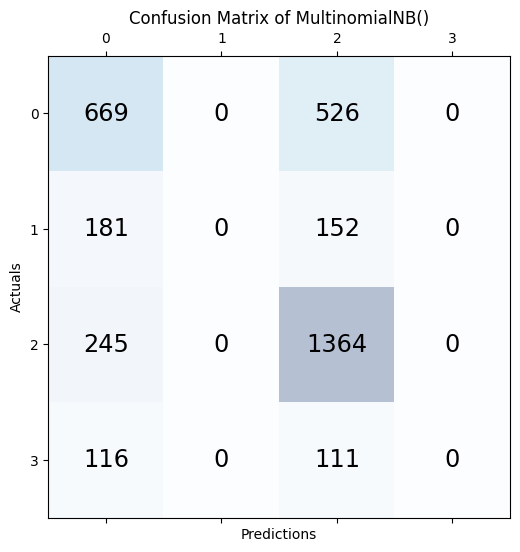



Embeddings:  KeyedVectors<vector_size=600, 929606 keys> | Classifier: KNeighborsClassifier()
Validation accuracy:  0.5356718192627824
Train accuracy:  0.6569008343417617
Validation precision:  0.45476246288899436
Validation Recall:  0.37328936243429994
Validation f1-score:  0.3697976530163332
Train f1-score:  0.49698564405594425




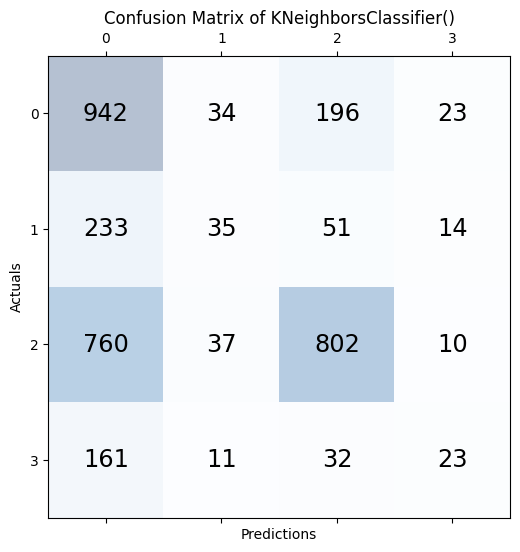



Embeddings:  KeyedVectors<vector_size=600, 929606 keys> | Classifier: DecisionTreeClassifier()
Validation accuracy:  0.45422116527942924
Train accuracy:  0.9998089293675562
Validation precision:  0.33385102355769025
Validation Recall:  0.3370964952938951
Validation f1-score:  0.3349353780430967
Train f1-score:  0.9997817143049205




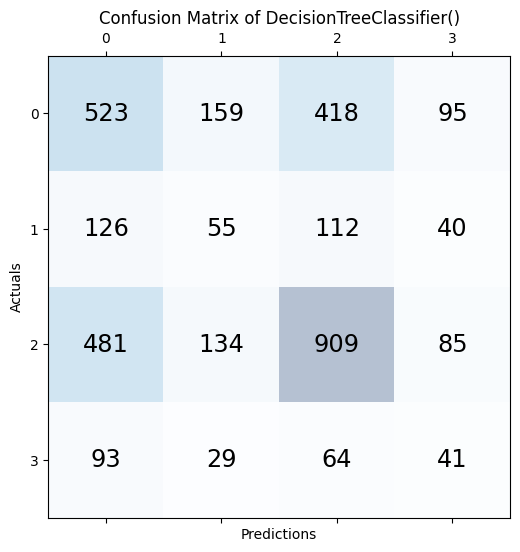



Embeddings:  KeyedVectors<vector_size=600, 929606 keys> | Classifier: RandomForestClassifier()
Validation accuracy:  0.6263376932223543
Train accuracy:  0.9998089293675562
Validation precision:  0.6612162826109785
Validation Recall:  0.37602801088749066
Validation f1-score:  0.35455598883527867
Train f1-score:  0.9997817066813846




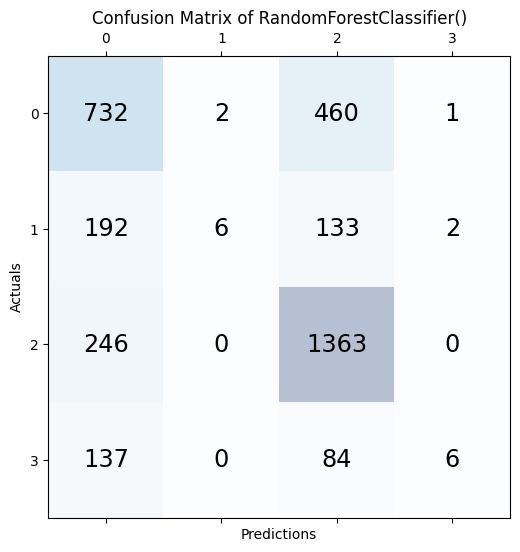



Embeddings:  KeyedVectors<vector_size=600, 929606 keys> | Classifier: GradientBoostingClassifier()
Validation accuracy:  0.6495243757431629
Train accuracy:  0.7214190178969493
Validation precision:  0.5296517428781298
Validation Recall:  0.43070995903568354
Validation f1-score:  0.4319827470603179
Train f1-score:  0.5688739100568628




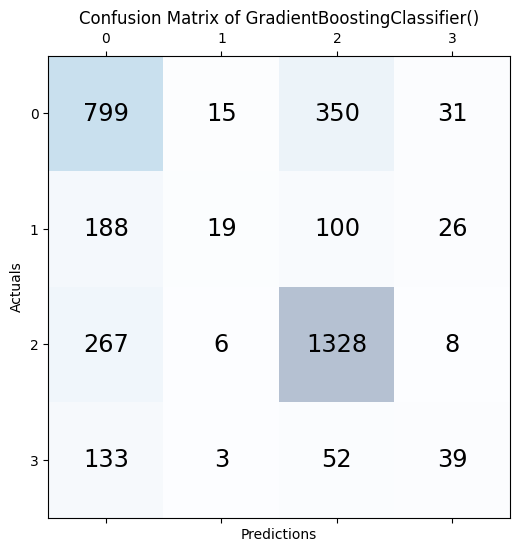



Embeddings:  KeyedVectors<vector_size=600, 929606 keys> | Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
Validation accuracy:  0.6447681331747919
Train accuracy:  0.999681548945927
Validation precision:  0.5056791933018613
Validation Recall:  0.42294941364688726
Validatio

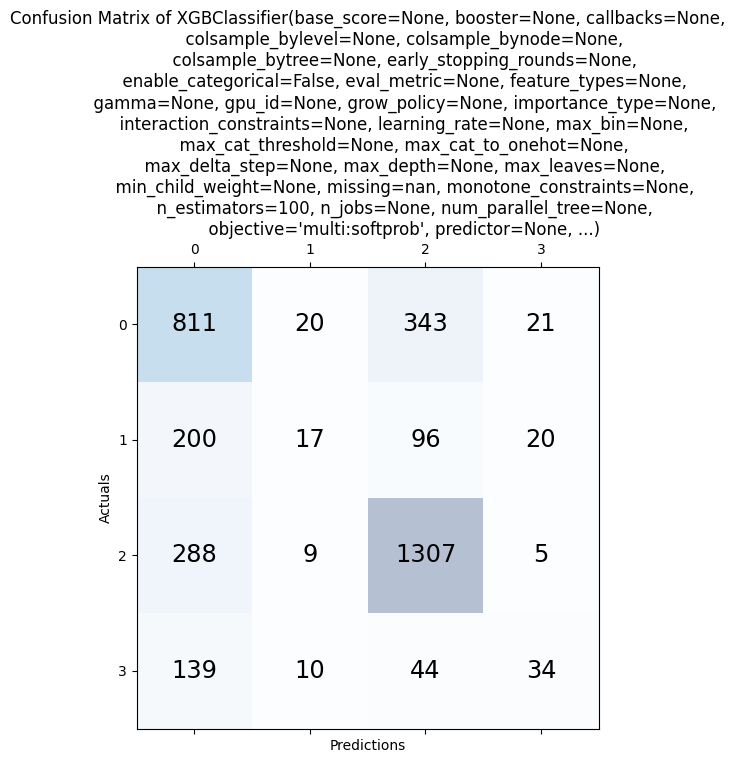



Embeddings:  KeyedVectors<vector_size=600, 929606 keys> | Classifier: LinearSVC()
Validation accuracy:  0.6453626634958383
Train accuracy:  0.682185848035157
Validation precision:  0.5232305134760438
Validation Recall:  0.4337034571966599
Validation f1-score:  0.4404514416381944
Train f1-score:  0.49094608501357906




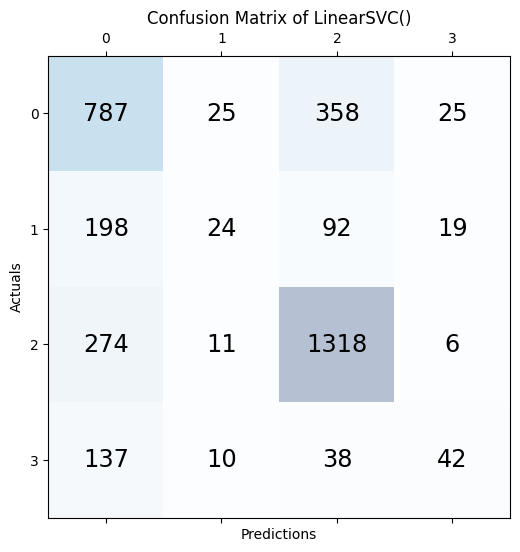

In [39]:
feature_set=['narrative_embeddings', 'embeddings_title']
same_string_combination(classifiers, feature_set, X_train, X_val, y_train, y_val, w2v)

Embeddings:  KeyedVectors<vector_size=600, 929605 keys> | Classifier: MultinomialNB()
Validation accuracy:  0.5930439952437574
Train accuracy:  0.5857588688618559
Validation precision:  0.2907247391229702
Validation Recall:  0.3462558932365278
Validation f1-score:  0.31516741648925034
Train f1-score:  0.310415920208508




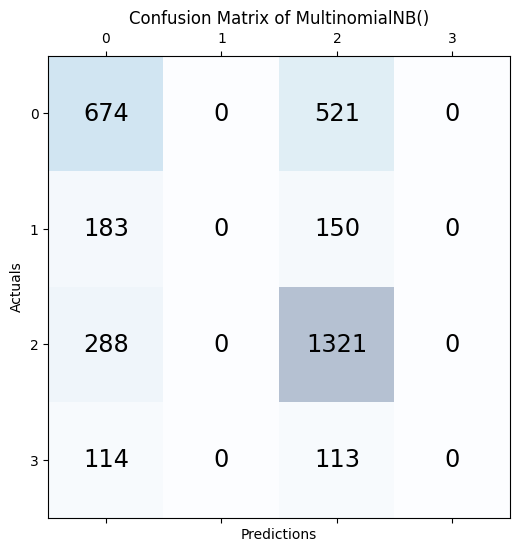



Embeddings:  KeyedVectors<vector_size=600, 929605 keys> | Classifier: KNeighborsClassifier()
Validation accuracy:  0.5041617122473246
Train accuracy:  0.653525253168588
Validation precision:  0.39773985215609015
Validation Recall:  0.34435399945278006
Validation f1-score:  0.33480350040880846
Train f1-score:  0.489660708936075




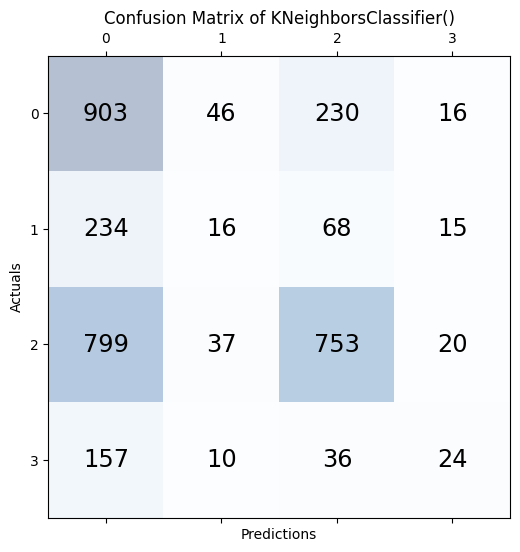



Embeddings:  KeyedVectors<vector_size=600, 929605 keys> | Classifier: DecisionTreeClassifier()
Validation accuracy:  0.45422116527942924
Train accuracy:  0.9998089293675562
Validation precision:  0.32284282695791205
Validation Recall:  0.3241481079621898
Validation f1-score:  0.3232074849002626
Train f1-score:  0.9997817143049205




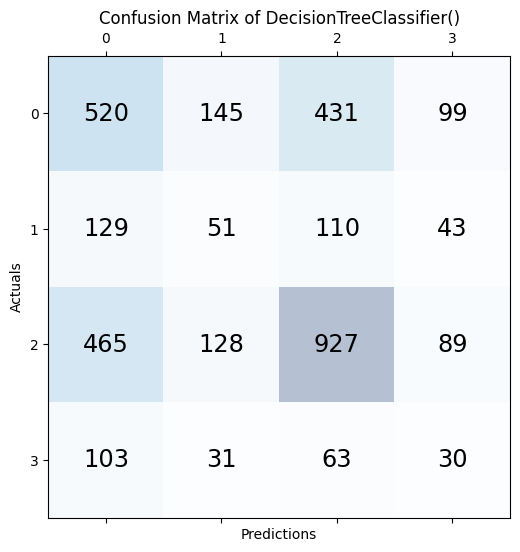



Embeddings:  KeyedVectors<vector_size=600, 929605 keys> | Classifier: RandomForestClassifier()
Validation accuracy:  0.6192033293697978
Train accuracy:  0.9998089293675562
Validation precision:  0.6469456617281446
Validation Recall:  0.3676847925587336
Validation f1-score:  0.3434638849536495
Train f1-score:  0.9997818054512724




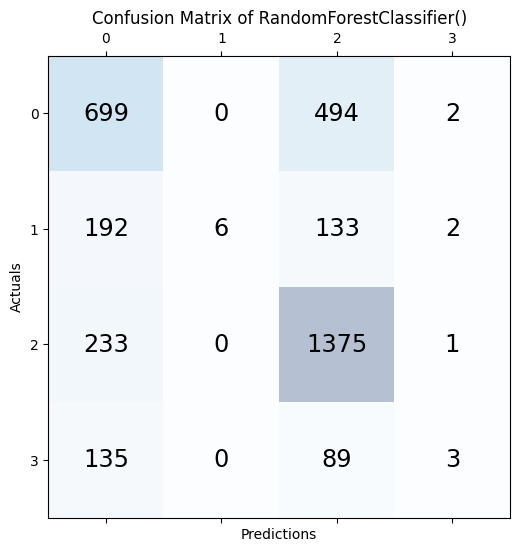



Embeddings:  KeyedVectors<vector_size=600, 929605 keys> | Classifier: GradientBoostingClassifier()
Validation accuracy:  0.6382282996432818
Train accuracy:  0.7204636647347302
Validation precision:  0.5165566017728894
Validation Recall:  0.41021481622751704
Validation f1-score:  0.4078279498978781
Train f1-score:  0.5661593145620006




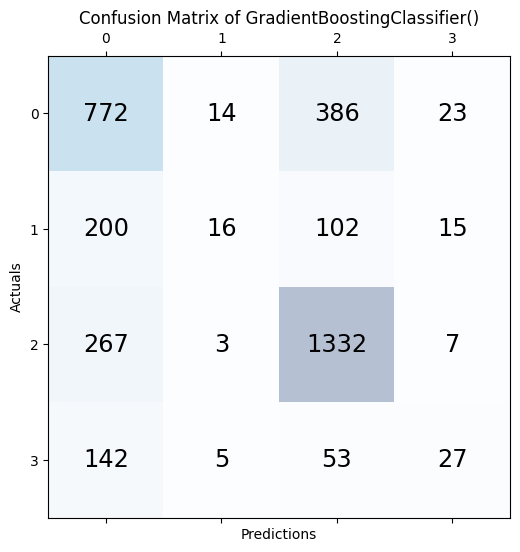



Embeddings:  KeyedVectors<vector_size=600, 929605 keys> | Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
Validation accuracy:  0.6307966706302022
Train accuracy:  0.9994904783134833
Validation precision:  0.5144293924466339
Validation Recall:  0.4115446049574984
Validatio

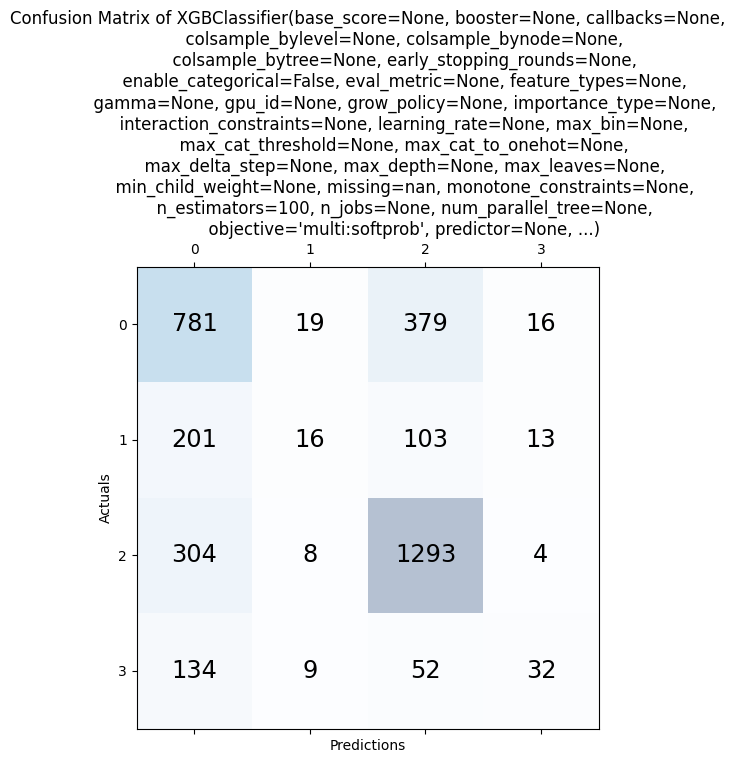



Embeddings:  KeyedVectors<vector_size=600, 929605 keys> | Classifier: LinearSVC()
Validation accuracy:  0.6414982164090368
Train accuracy:  0.6796382396025731
Validation precision:  0.520618729673022
Validation Recall:  0.4337429319275223
Validation f1-score:  0.43840812776281096
Train f1-score:  0.4917487687006476




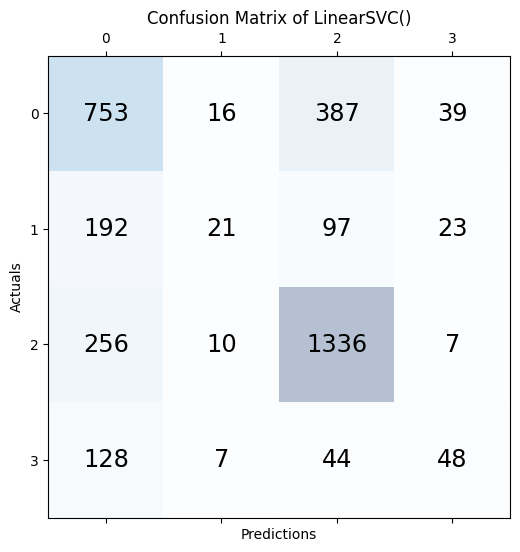

In [40]:
feature_set=['narrative_embeddings', 'embeddings_title']
same_string_combination(classifiers, feature_set, X_train, X_val, y_train, y_val, glove)

## without title

Embeddings:  KeyedVectors<vector_size=600, 929606 keys> | Classifier: MultinomialNB()
Validation accuracy:  0.5909631391200951
Train accuracy:  0.5858862492834851
Validation precision:  0.2899445596378992
Validation Recall:  0.34226149457419175
Validation f1-score:  0.3112544019502581
Train f1-score:  0.30679950986453675




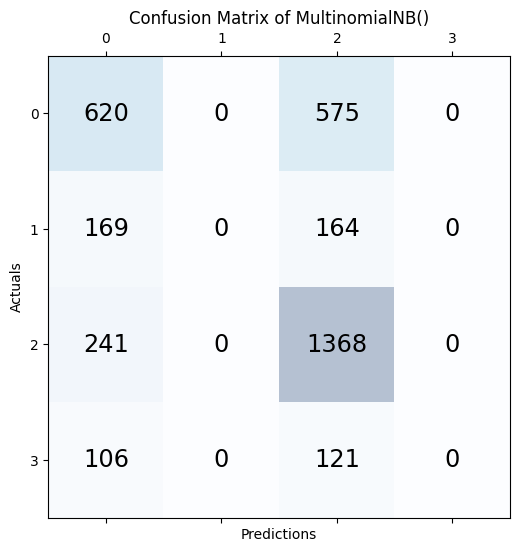



Embeddings:  KeyedVectors<vector_size=600, 929606 keys> | Classifier: KNeighborsClassifier()
Validation accuracy:  0.5166468489892985
Train accuracy:  0.6432711292274378
Validation precision:  0.4277198821677161
Validation Recall:  0.3547119450747994
Validation f1-score:  0.3440270635637469
Train f1-score:  0.47526343502266555




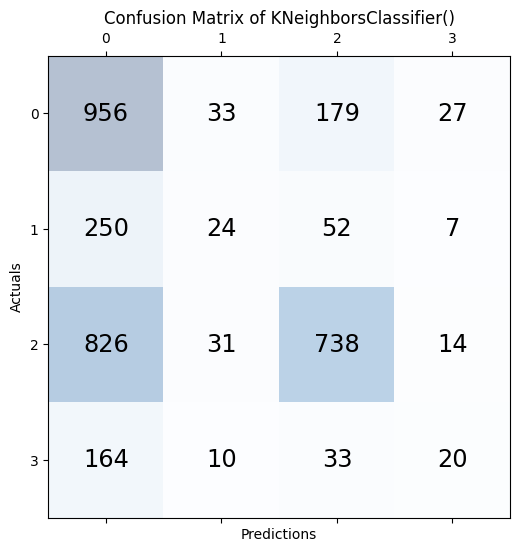



Embeddings:  KeyedVectors<vector_size=600, 929606 keys> | Classifier: DecisionTreeClassifier()
Validation accuracy:  0.47265160523186683
Train accuracy:  0.9994904783134833
Validation precision:  0.3494639793083981
Validation Recall:  0.3536248807467761
Validation f1-score:  0.35093343626819273
Train f1-score:  0.99946453251754




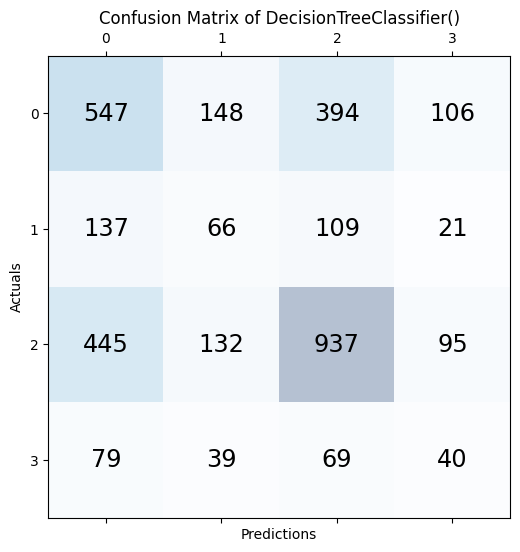



Embeddings:  KeyedVectors<vector_size=600, 929606 keys> | Classifier: RandomForestClassifier()
Validation accuracy:  0.6200951248513674
Train accuracy:  0.9994904783134833
Validation precision:  0.6208740927977419
Validation Recall:  0.36852772366540093
Validation f1-score:  0.34438046771599645
Train f1-score:  0.9994645558920403




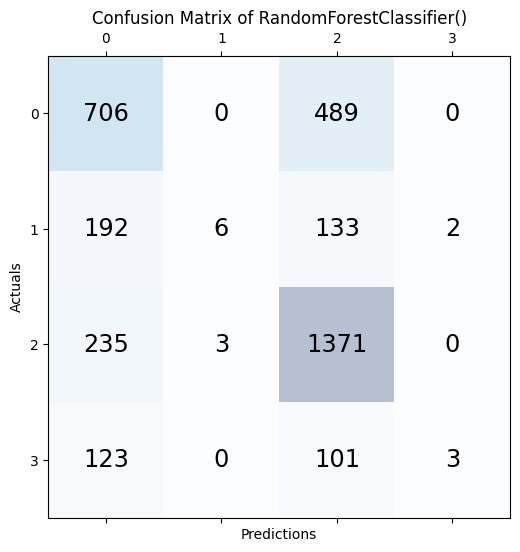



Embeddings:  KeyedVectors<vector_size=600, 929606 keys> | Classifier: GradientBoostingClassifier()
Validation accuracy:  0.6435790725326992
Train accuracy:  0.713075600280237
Validation precision:  0.48947788515269686
Validation Recall:  0.4093027166428125
Validation f1-score:  0.40320177466663476
Train f1-score:  0.5536230686080912




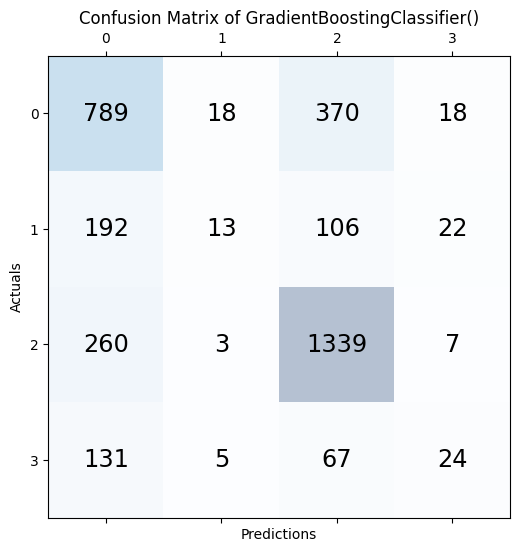



Embeddings:  KeyedVectors<vector_size=600, 929606 keys> | Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
Validation accuracy:  0.6319857312722948
Train accuracy:  0.9992357174702248
Validation precision:  0.5117792095941597
Validation Recall:  0.4088199965862257
Validatio

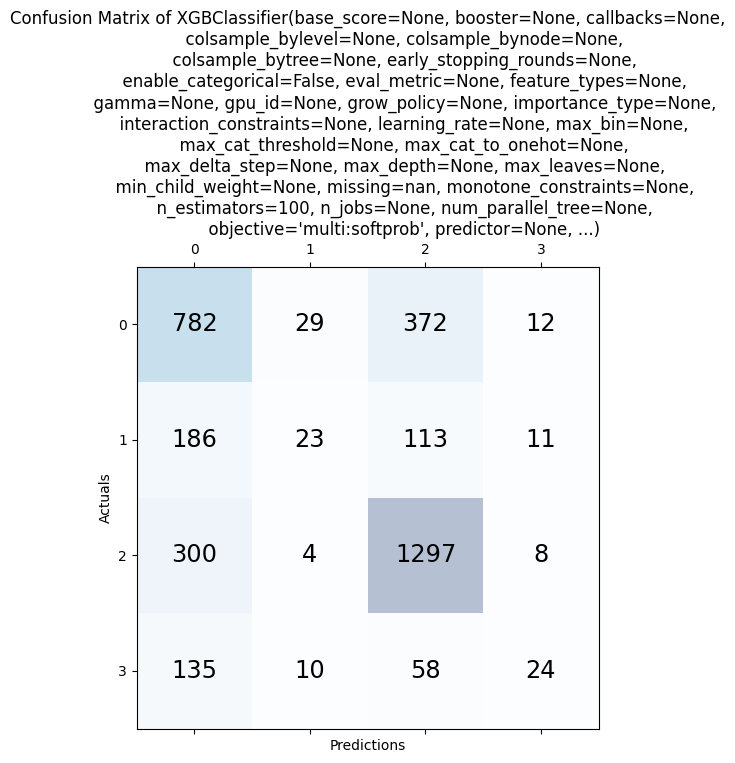



Embeddings:  KeyedVectors<vector_size=600, 929606 keys> | Classifier: LinearSVC()
Validation accuracy:  0.6429845422116528
Train accuracy:  0.6685561429208331
Validation precision:  0.4938977122441241
Validation Recall:  0.4257736545196884
Validation f1-score:  0.4206303198704351
Train f1-score:  0.45937320981847996




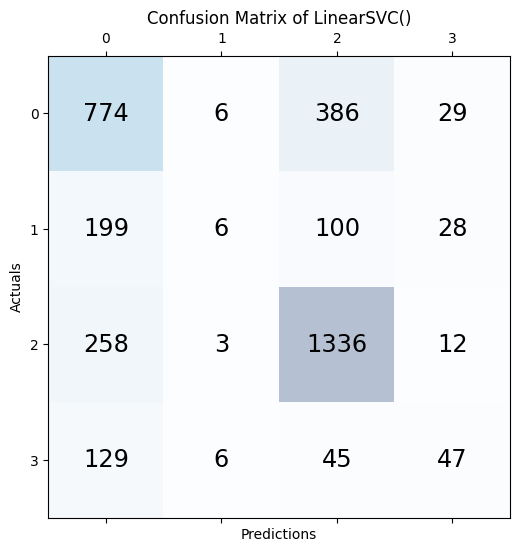

In [41]:
feature_set=['narrative_embeddings']
same_string_combination(classifiers, feature_set, X_train, X_val, y_train, y_val, w2v)

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Embeddings:  KeyedVectors<vector_size=600, 929605 keys> | Classifier: MultinomialNB()
Validation accuracy:  0.5850178359096314
Train accuracy:  0.5760142666072224
Validation precision:  0.286533738473047
Validation Recall:  0.3394231194301926
Validation f1-score:  0.3086970287026937
Train f1-score:  0.30208015512765823




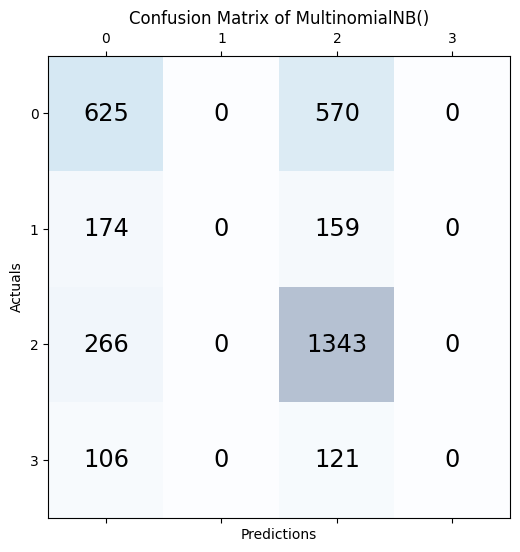



Embeddings:  KeyedVectors<vector_size=600, 929605 keys> | Classifier: KNeighborsClassifier()
Validation accuracy:  0.4997027348394768
Train accuracy:  0.637857461308197
Validation precision:  0.4259116647695811
Validation Recall:  0.34393875364199794
Validation f1-score:  0.3333505031294656
Train f1-score:  0.4671095195207274




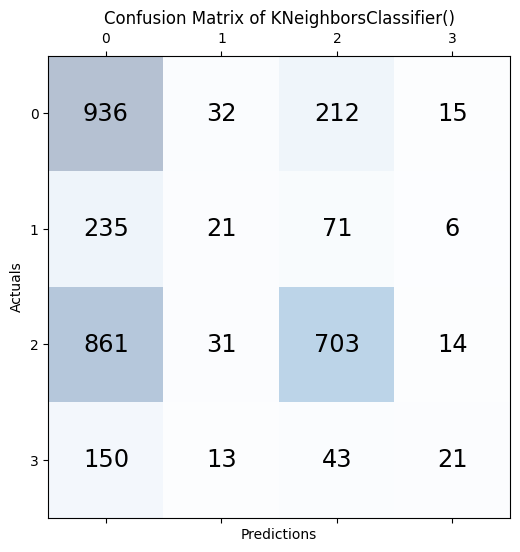



Embeddings:  KeyedVectors<vector_size=600, 929605 keys> | Classifier: DecisionTreeClassifier()
Validation accuracy:  0.44916765755053506
Train accuracy:  0.9994904783134833
Validation precision:  0.3234760001355407
Validation Recall:  0.3242945056949511
Validation f1-score:  0.32364517307865237
Train f1-score:  0.99946453251754




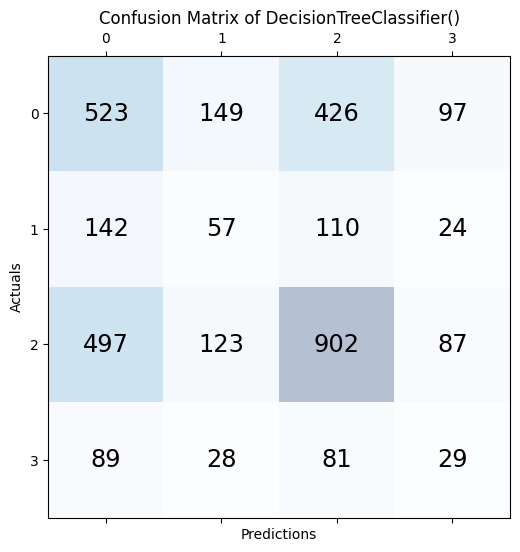



Embeddings:  KeyedVectors<vector_size=600, 929605 keys> | Classifier: RandomForestClassifier()
Validation accuracy:  0.6180142687277052
Train accuracy:  0.9994904783134833
Validation precision:  0.7192853414757064
Validation Recall:  0.3683616960225236
Validation f1-score:  0.34569923836228184
Train f1-score:  0.9994644124690616




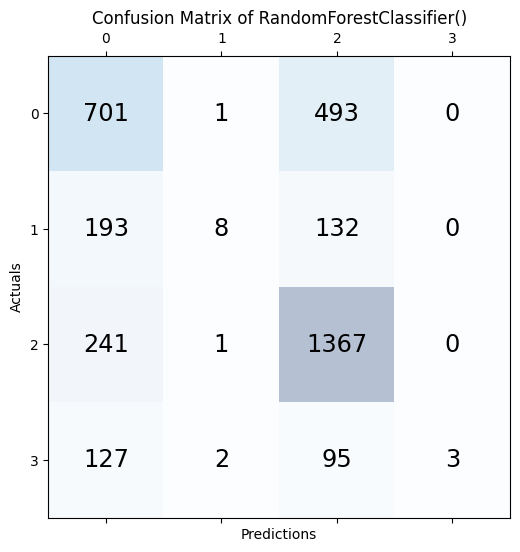



Embeddings:  KeyedVectors<vector_size=600, 929605 keys> | Classifier: GradientBoostingClassifier()
Validation accuracy:  0.6126634958382877
Train accuracy:  0.71020954079358
Validation precision:  0.45455979426515547
Validation Recall:  0.3855052260436521
Validation f1-score:  0.3769068036632532
Train f1-score:  0.5454195017799769




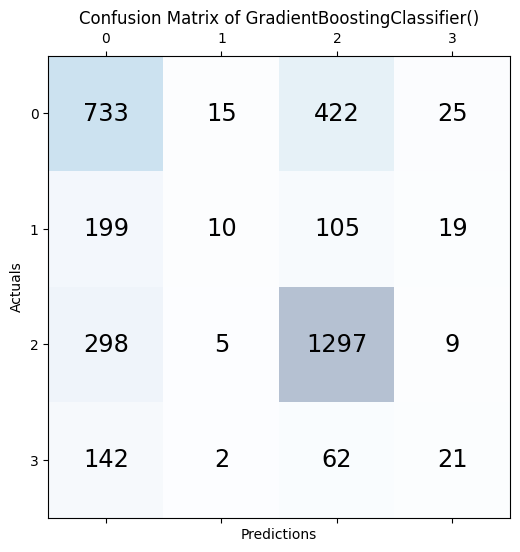



Embeddings:  KeyedVectors<vector_size=600, 929605 keys> | Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
Validation accuracy:  0.6299048751486326
Train accuracy:  0.9991083370485956
Validation precision:  0.5483218645598082
Validation Recall:  0.4082476780047648
Validatio

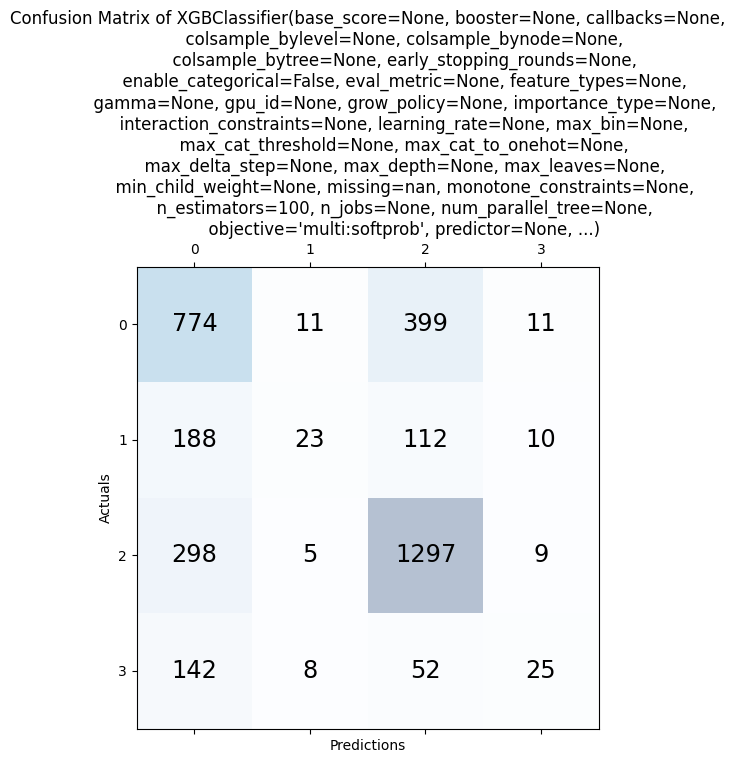

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Embeddings:  KeyedVectors<vector_size=600, 929605 keys> | Classifier: LinearSVC()
Validation accuracy:  0.6316884661117717
Train accuracy:  0.6695751862938666
Validation precision:  0.5076743262905298
Validation Recall:  0.42563781193256756
Validation f1-score:  0.4308943244032811
Train f1-score:  0.47519788740831703




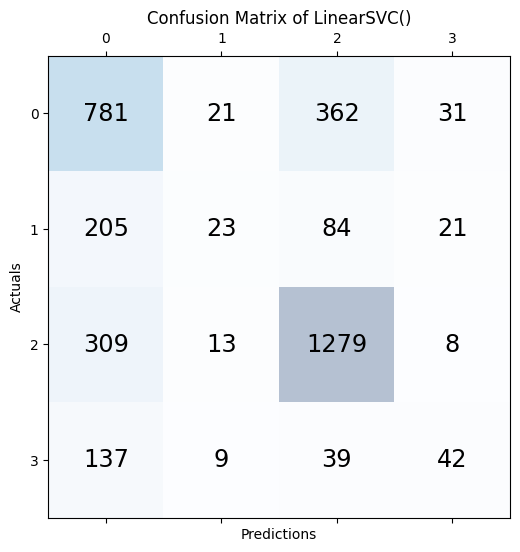

In [10]:
feature_set=['narrative_embeddings']
same_string_combination(classifiers, feature_set, X_train, X_val, y_train, y_val, glove)